In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import riskfolio as rp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
print(rp.__version__) 

7.0.0


In [357]:
assets = {
    'SPY': 'SP 500',
    'VWRD.L': 'MSCI WORLD',
    '^FCHI': 'CAC 40',
    '^GDAXI': 'DAX 40',
    '^N225': 'NIKKEI 225',
    'BTC-USD': 'BTC',
    'DOGE-USD': 'DOGE',
    'ETH-USD': 'ETH',
    'XRP-USD': 'XRP',
    'ADA-USD': 'ADA',
    'GC=F': 'GOLD',
    'SI=F': 'SILVER',
    'BND': 'US BOND',
    'IXUS': 'WORLD EX-US',
    'TLT': 'US TREASURY',
    'VWO': 'EMERGING MARKETS',
    'BNDX': 'WORLD BOND',
    'VYM': 'HIGH DIVIDEND',
    'VNQ': 'REAL ESTATE',
}


data = yf.download(list(assets.keys()), start='2022-01-01', end='2024-01-01', interval='1d')

if isinstance(data.columns, pd.MultiIndex):
    data.columns = pd.MultiIndex.from_tuples([(col[0], assets.get(col[1], col[1])) for col in data.columns])
    data = data.xs("Close", axis=1, level=0)
else:
    data.rename(columns=assets, inplace=True)

data.columns

[*********************100%***********************]  19 of 19 completed


Index(['ADA', 'US BOND', 'WORLD BOND', 'BTC', 'DOGE', 'ETH', 'GOLD',
       'WORLD EX-US', 'SILVER', 'SP 500', 'US TREASURY', 'REAL ESTATE',
       'EMERGING MARKETS', 'MSCI WORLD', 'HIGH DIVIDEND', 'XRP', 'CAC 40',
       'DAX 40', 'NIKKEI 225'],
      dtype='object')

In [358]:
data


,ADA,US BOND,WORLD BOND,BTC,DOGE,ETH,GOLD,WORLD EX-US,SILVER,SP 500,US TREASURY,REAL ESTATE,EMERGING MARKETS,MSCI WORLD,HIGH DIVIDEND,XRP,CAC 40,DAX 40,NIKKEI 225
Date,,,,,,,,,,,,,,,,,,,
2022-01-01,1.376975,NaN,NaN,47686.812500,0.173035,3769.697021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.849472,NaN,NaN,NaN
2022-01-02,1.377584,NaN,NaN,47345.218750,0.174403,3829.564941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.859118,NaN,NaN,NaN
2022-01-03,1.321637,76.268013,49.553265,46458.117188,0.170088,3761.380371,1799.400024,65.322243,22.790001,455.810394,129.997269,101.184364,44.706779,NaN,102.061104,0.832885,7217.220215,16020.730469,NaN
2022-01-04,1.311658,76.258926,49.562267,45897.574219,0.168803,3794.056641,1814.000000,65.432182,23.038000,455.657776,129.456680,101.061279,44.527275,117.424545,103.311478,0.824673,7317.410156,16152.610352,29301.789062
2022-01-05,1.236002,75.996193,49.463139,43569.003906,0.159420,3550.386963,1824.599976,64.745148,23.150000,446.908173,128.754028,98.169037,43.863087,117.424545,102.921860,0.774358,7376.370117,16271.750000,29332.160156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.633535,70.824120,47.499474,43442.855469,0.093579,2378.739990,2081.899902,62.807812,24.375000,469.064056,95.899353,84.535713,39.433002,116.754173,107.962051,0.634856,7571.819824,16742.070312,33681.238281
2023-12-28,0.617422,70.651604,47.337044,42627.855469,0.091884,2347.566162,2073.899902,62.846546,24.134001,469.241241,95.202835,85.135521,39.674984,117.058266,107.981377,0.634998,7535.160156,16701.550781,33539.621094
2023-12-29,0.608494,70.488686,47.174595,42099.402344,0.091038,2300.690674,2062.399902,62.875595,23.853001,467.882782,94.344116,84.126312,39.781448,117.019043,107.788246,0.623402,7543.180176,16751.640625,33464.171875


In [359]:
returns = data[assets.values()].pct_change().dropna()
returns

C:\Users\antoi\AppData\Local\Temp\ipykernel_7676\4145395806.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data[assets.values()].pct_change().dropna()


,SP 500,MSCI WORLD,CAC 40,DAX 40,NIKKEI 225,BTC,DOGE,ETH,XRP,ADA,GOLD,SILVER,US BOND,WORLD EX-US,US TREASURY,EMERGING MARKETS,WORLD BOND,HIGH DIVIDEND,REAL ESTATE
Date,,,,,,,,,,,,,,,,,,,
2022-01-05,-0.019202,0.000000,0.008057,0.007376,0.001036,-0.050734,-0.055586,-0.064224,-0.061012,-0.057680,0.005843,0.004862,-0.003445,-0.010500,-0.005428,-0.014916,-0.002000,-0.003771,-0.028619
2022-01-06,-0.000940,-0.016561,-0.017178,-0.013503,-0.028784,-0.009366,0.004974,-0.037173,0.009024,0.035421,-0.019676,-0.042160,-0.001073,-0.001980,0.002589,0.005729,-0.002186,0.003786,0.000896
2022-01-07,-0.003953,-0.002044,-0.004163,-0.006497,-0.000327,-0.037141,-0.032394,-0.065878,-0.023385,-0.053318,0.004640,0.009921,-0.002745,0.004111,-0.007188,0.005087,0.000182,0.004648,-0.006621
2022-01-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.004236,-0.019797,-0.031704,-0.020163,-0.019838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.004257,-0.005850,0.021274,0.009117,-0.011496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.001808,0.008260,0.000396,0.002148,0.011271,0.021694,0.024333,0.065999,0.020064,0.040631,0.011515,0.009568,0.006400,0.004958,0.017720,0.005429,0.005868,0.001074,0.004867
2023-12-28,0.000378,0.002605,-0.004842,-0.002420,-0.004205,-0.018760,-0.018113,-0.013105,0.000224,-0.025434,-0.003843,-0.009887,-0.002436,0.000617,-0.007263,0.006137,-0.003420,0.000179,0.007095
2023-12-29,-0.002895,-0.000335,0.001064,0.002999,-0.002250,-0.012397,-0.009207,-0.019968,-0.018262,-0.014460,-0.005545,-0.011643,-0.002306,0.000462,-0.009020,0.002683,-0.003432,-0.001789,-0.011854


In [360]:
port = rp.Portfolio(returns=returns)
hc_port = rp.HCPortfolio(returns=returns)

stats = port.assets_stats(method_mu="hist", method_cov="hist")


,SP 500,MSCI WORLD,CAC 40,DAX 40,NIKKEI 225,BTC,DOGE,ETH,XRP,ADA,GOLD,SILVER,US BOND,WORLD EX-US,US TREASURY,EMERGING MARKETS,WORLD BOND,HIGH DIVIDEND,REAL ESTATE
weights,4.332672e-08,1.852260e-08,9.592026e-09,3.82724,35.426078,0.49852,2.268118e-08,1.787687e-07,2.785493,3.600708e-07,53.175534,1.664358e-07,2.999631e-07,2.475851e-08,4.705217e-07,1.503674e-07,2.886939e-07,4.287132,1.192174e-07


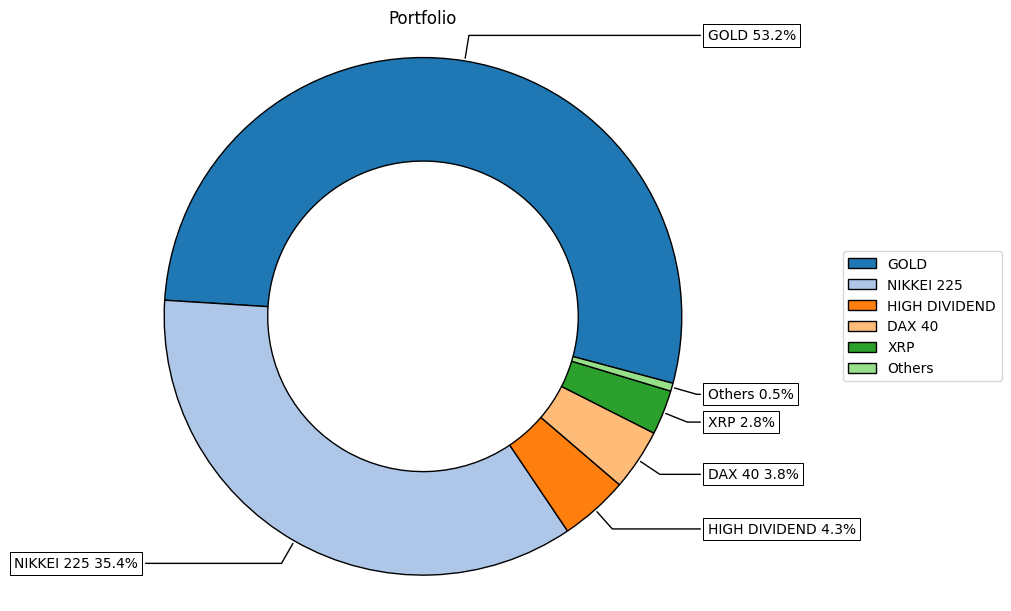

In [451]:
w1 = port.optimization(model='Classic', rm='MV', obj='Sharpe', rf=0, l=0, hist=True) # Sharpe, MinRisk, MaxRet

w2 = port.rp_optimization(model='Classic', rm='MV', rf=0, b=None, hist=True)

w3 = hc_port.optimization(
    model='NCO',
    codependence='pearson',
    obj='Sharpe',
    rm='MV',
    rf=0,
    linkage='single'
)

ws = port.efficient_frontier(model='Classic', rm='MV', points=30, rf=0, hist=True)

# w1: classic sharpe optimization
# w2: risk parity optimization (equal risk contribution)
# w3: Nested Clustered Optimization

w = w1

display(w.T*100)
ax = rp.plot_pie(w=w, title='Portfolio', others=0.01, nrow=25, cmap = "tab20",height=6, width=10, ax=None)

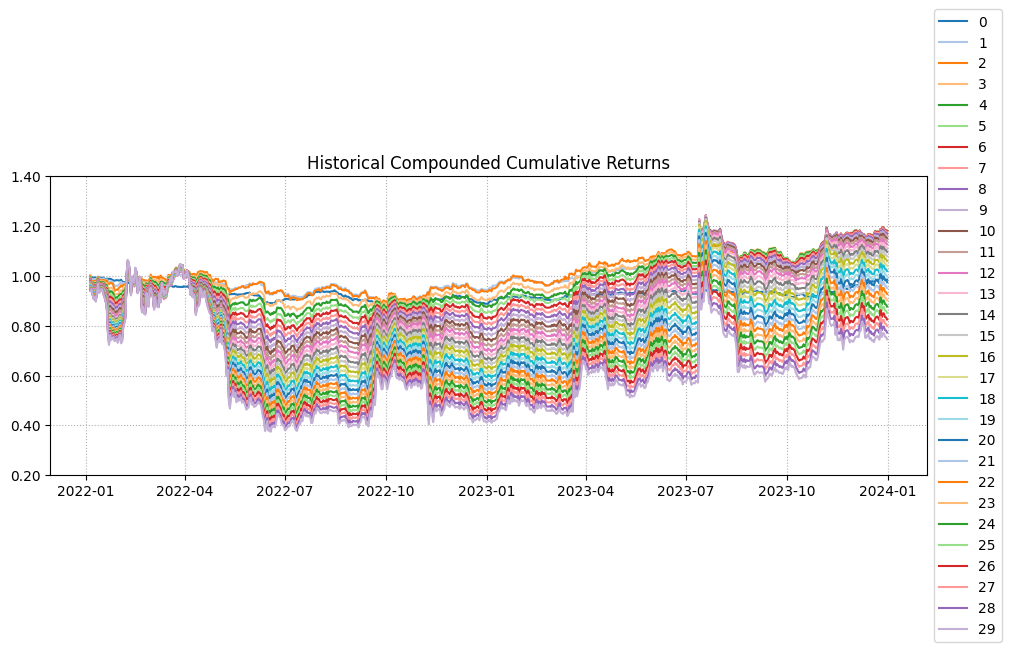

In [452]:
ax = rp.plot_series(returns=returns,w=ws,cmap='tab20',height=6,width=10,ax=None)

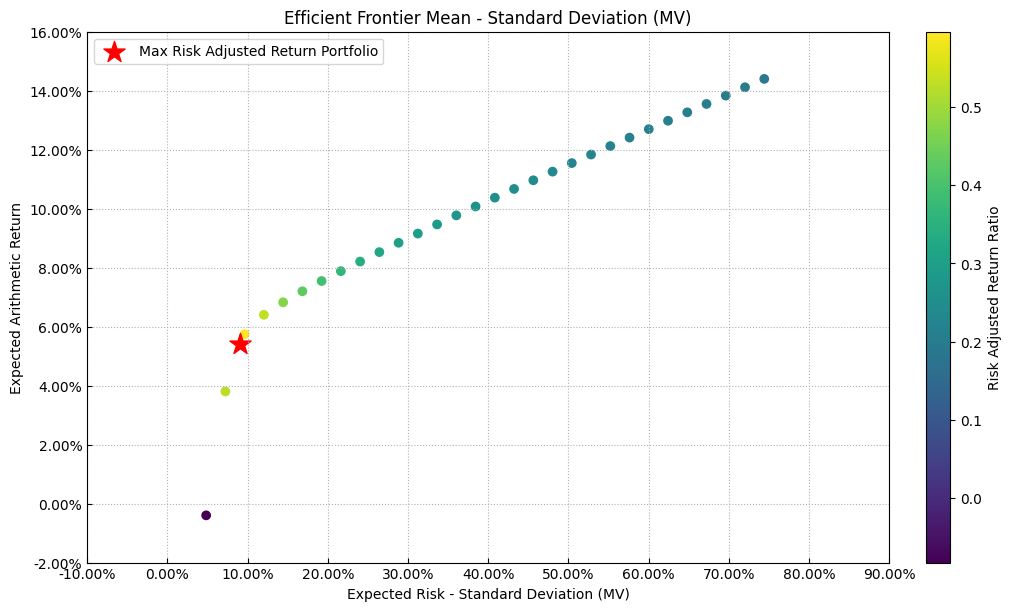

In [453]:
label = 'Max Risk Adjusted Return Portfolio'
mu = port.mu
cov = port.cov
returns = port.returns

ax = rp.plot_frontier(w_frontier=ws,mu=mu,cov=cov,returns=returns,rm="MV",rf=0,alpha=0.05,cmap='viridis',w=w,label=label,marker='*',s=16,c='r',height=6,width=10,t_factor=252,ax=None)

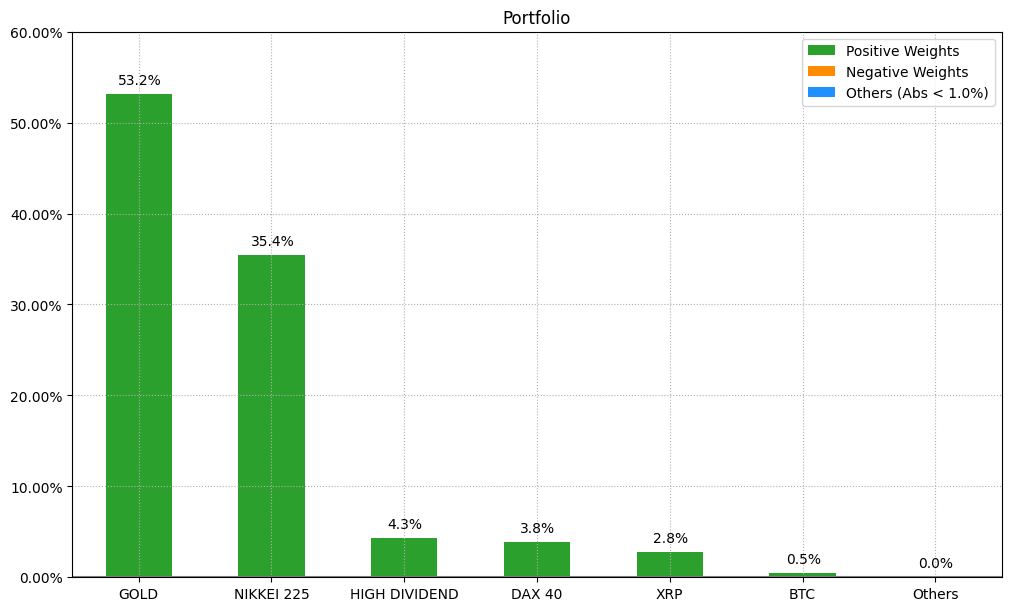

In [454]:
ax = rp.plot_bar(w,title='Portfolio',kind="v",others=0.05,nrow=25,height=6,width=10,ax=None)

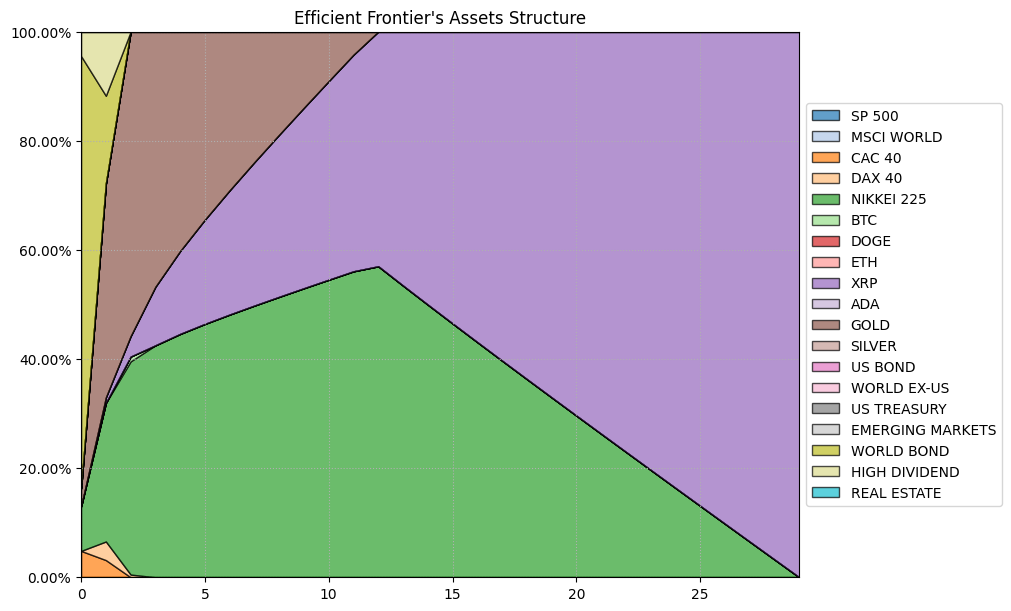

In [455]:
ax = rp.plot_frontier_area(w_frontier=ws,cmap="tab20",height=6,width=10,ax=None)

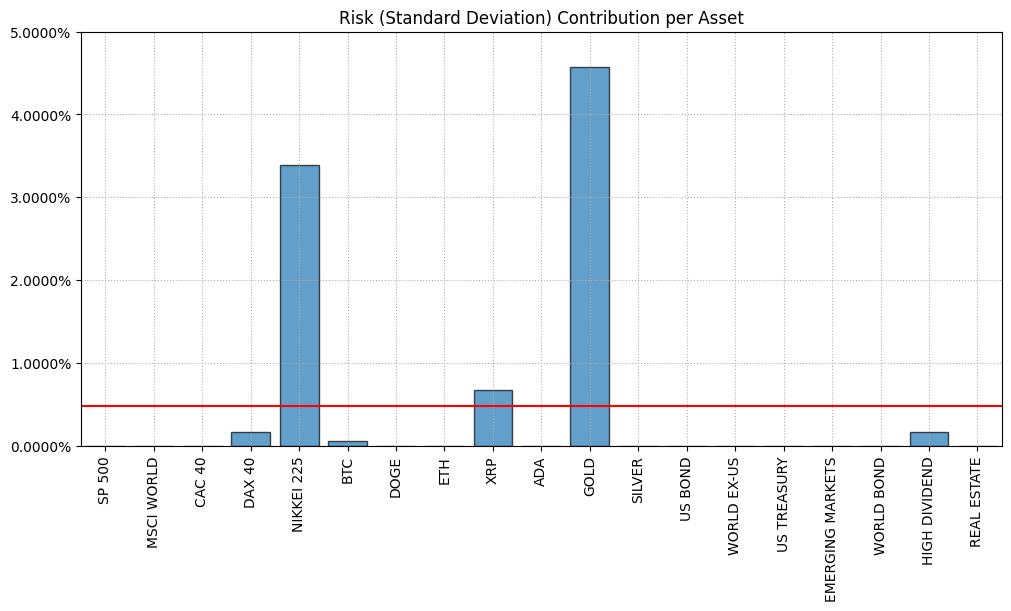

In [456]:
ax = rp.plot_risk_con(w=w,cov=cov,returns=returns,rm="MV",rf=0,alpha=0.05,color="tab:blue",height=6,width=10,t_factor=252,ax=None)

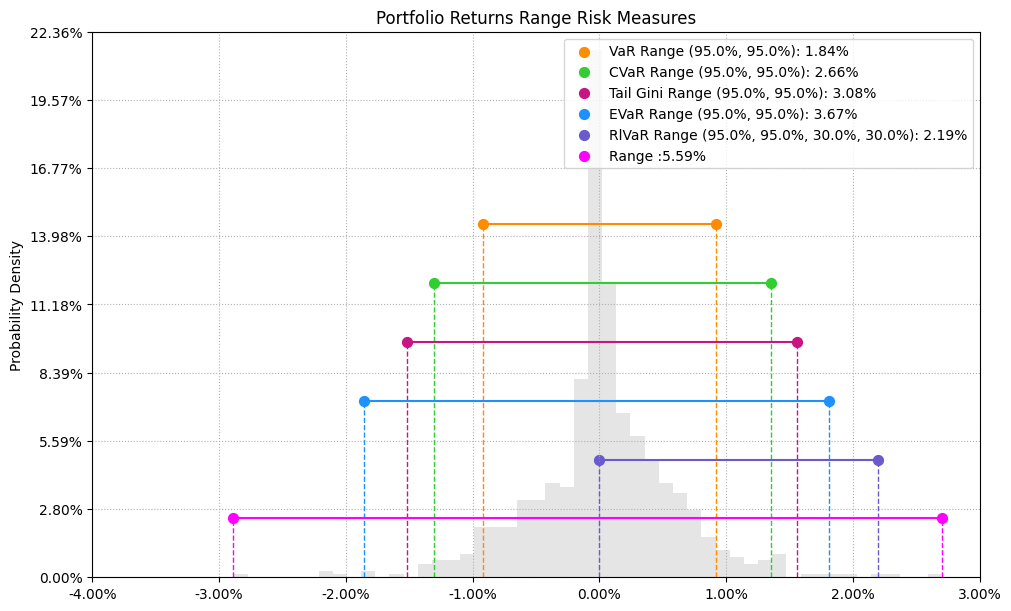

In [457]:
ax = rp.plot_range(returns=returns,w=w,alpha=0.05,a_sim=100,beta=None,b_sim=None,bins=50,height=6,width=10,ax=None)

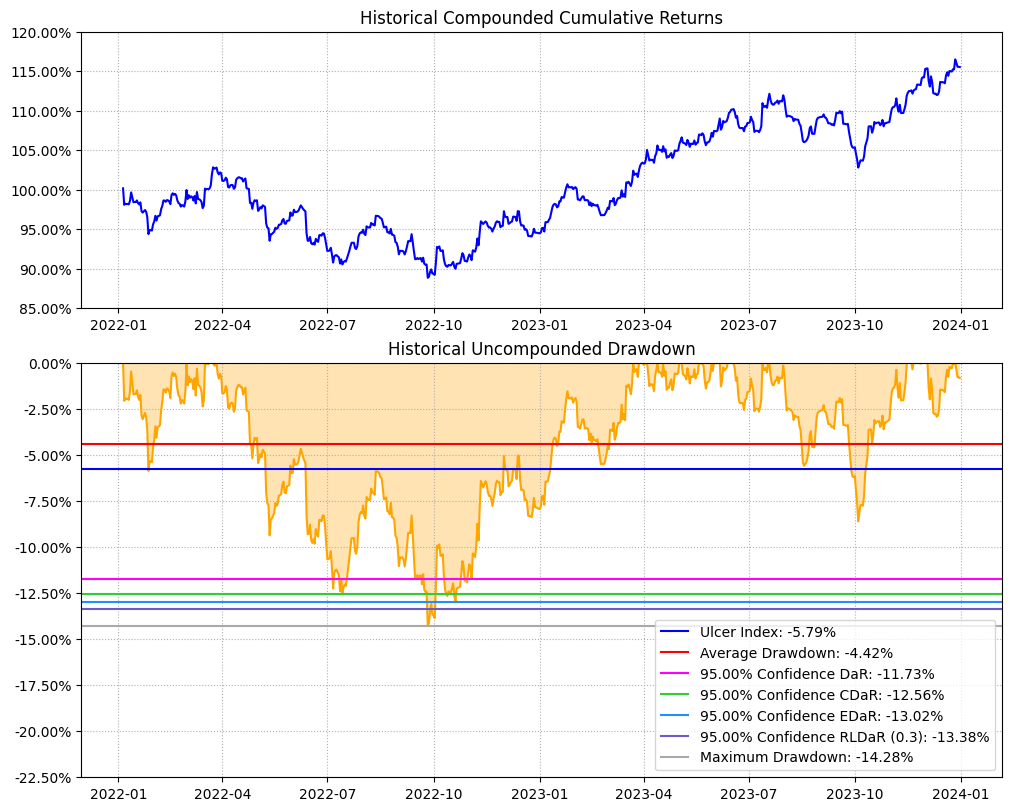

In [458]:
ax = rp.plot_drawdown(returns=returns,w=w,alpha=0.05,height=8,width=10,ax=None)

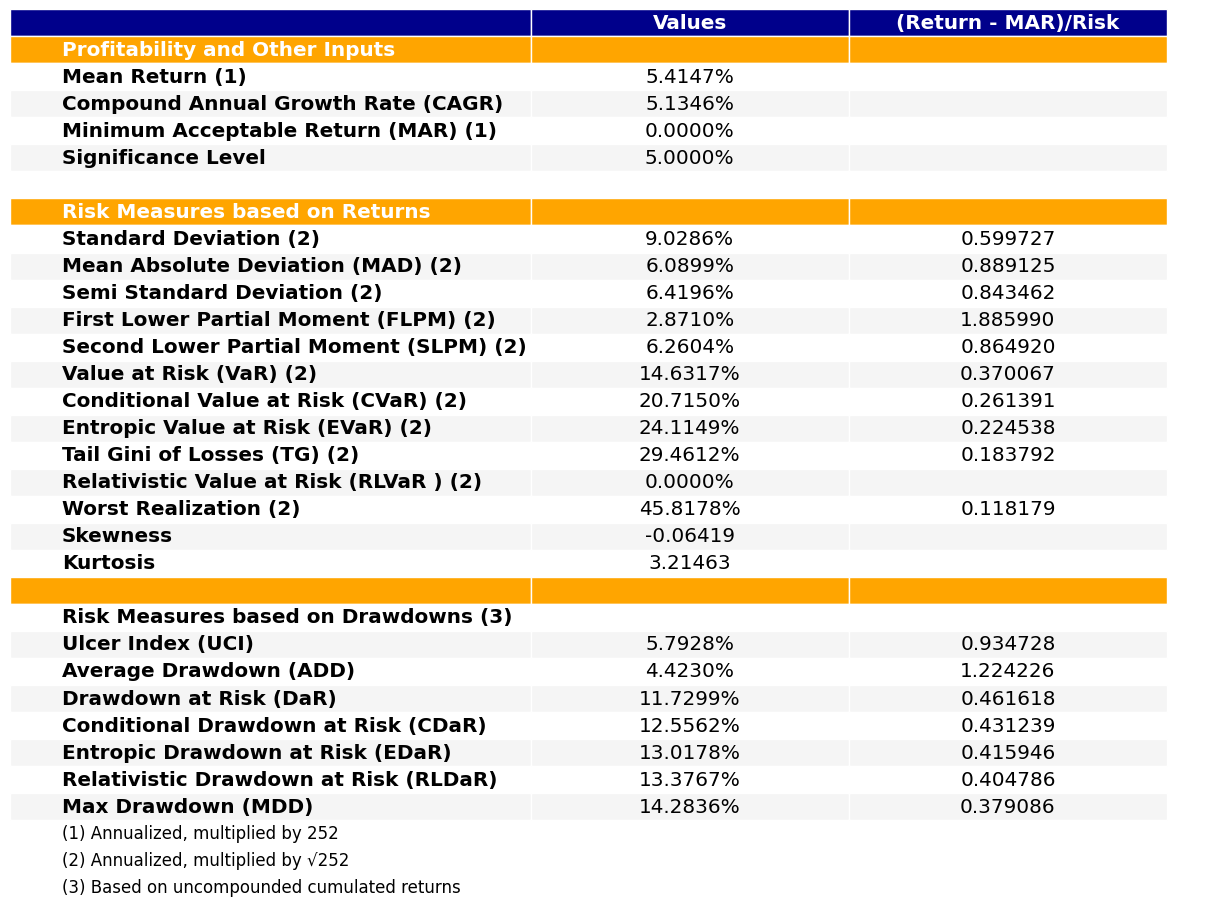

In [459]:
ax = rp.plot_table(returns=returns,w=w,MAR=0,alpha=0.05,ax=None)

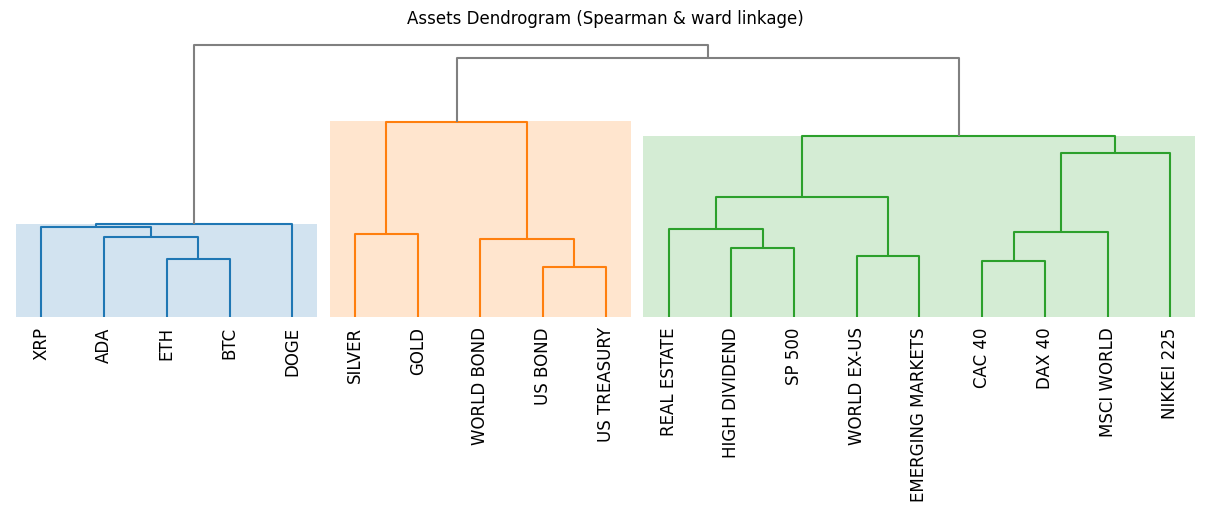

In [460]:
ax = rp.plot_dendrogram(returns=returns,codependence='spearman',linkage='ward',k=None,max_k=10,leaf_order=True,ax=None)

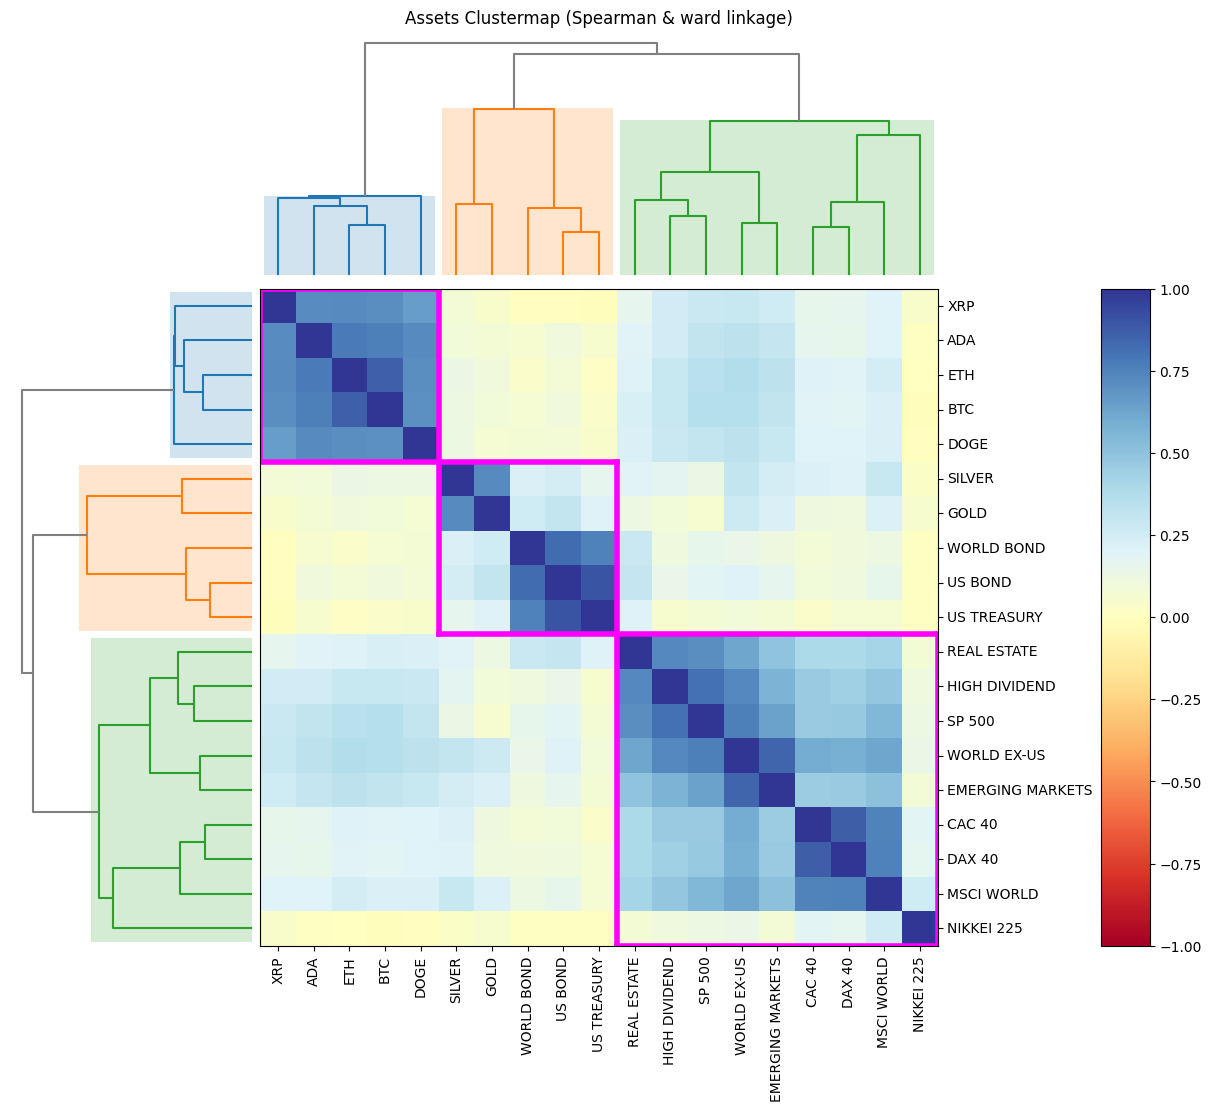

In [461]:
ax = rp.plot_clusters(returns=returns,codependence='spearman',linkage='ward',k=None,max_k=10,leaf_order=True,dendrogram=True,ax=None)

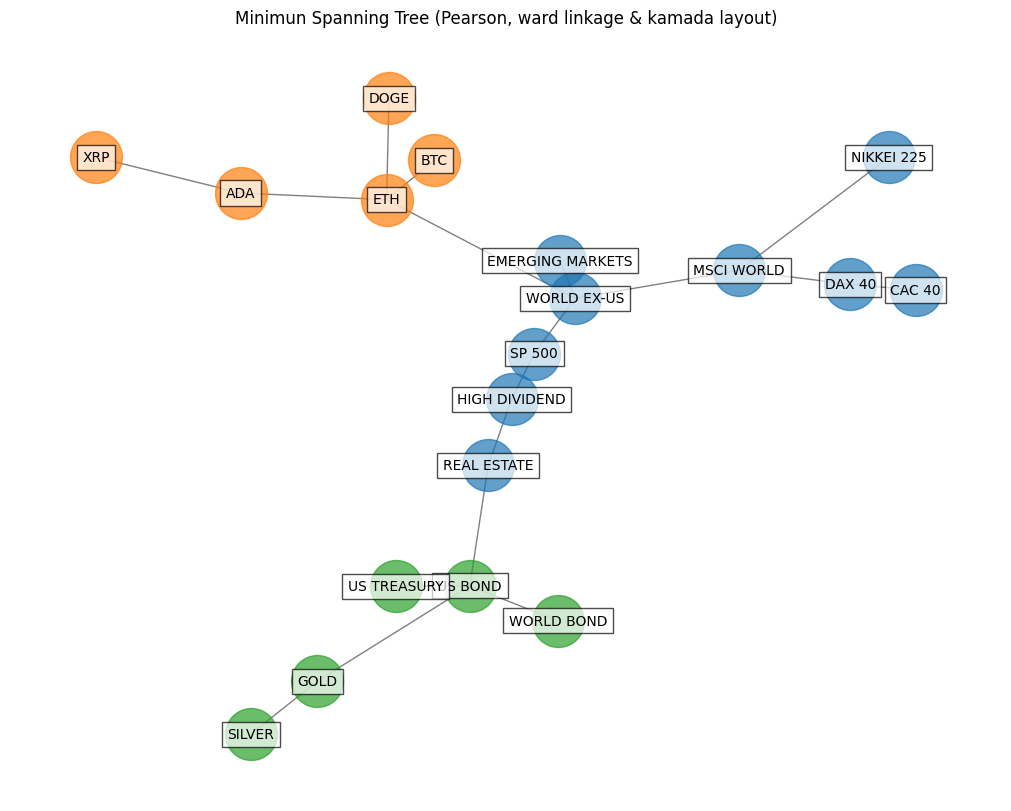

In [462]:
ax = rp.plot_network(returns=returns,codependence="pearson",linkage="ward",k=None,max_k=10,alpha_tail=0.05,leaf_order=True,kind='kamada',ax=None)

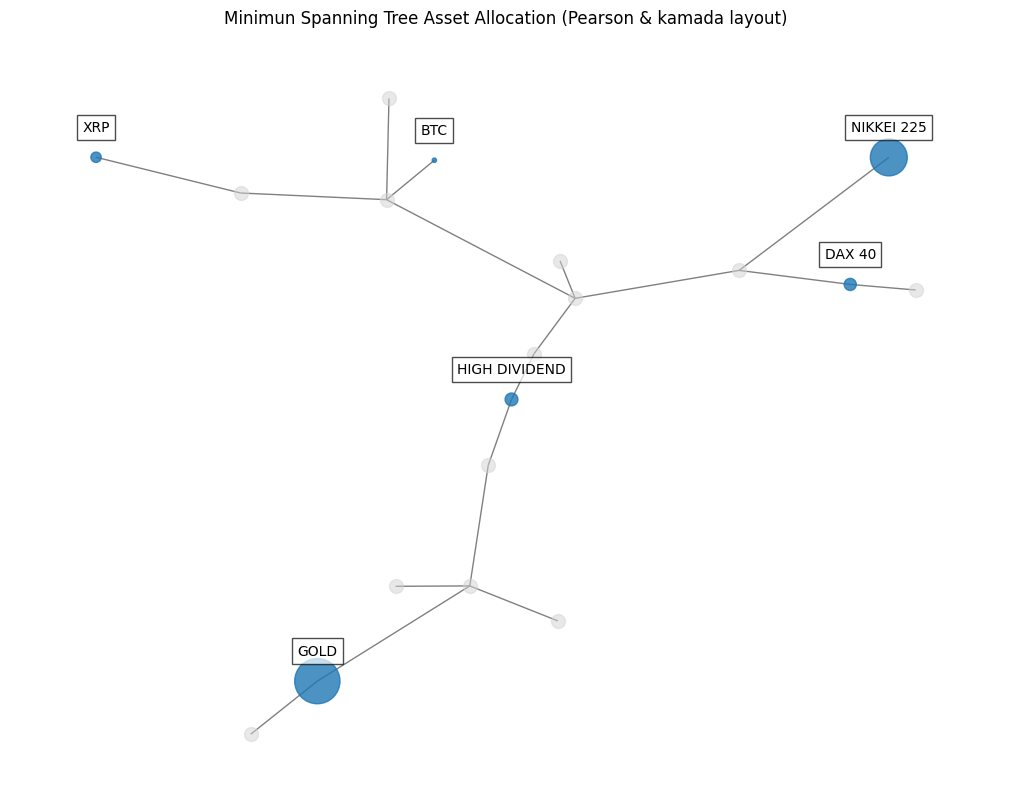

In [463]:
ax = rp.plot_network_allocation(returns=returns,w=w,codependence="pearson",linkage="ward",alpha_tail=0.05,leaf_order=True,kind='kamada',ax=None)